## BOAR with SIMsalabim
Version 1.00
(c) Larry Lueer, Vincent M. Le Corre, i-MEET 2021-2023

This notebook is made to use BOAR in combination with drift-diffusion modeling to fit of 'fake' JV curves.  
To perform the drift-diffusion simulation in the background we use the open-source program [SIMsalabim](https://github.com/kostergroup/SIMsalabim), for more information about SIMsalabim please check the [GitHub repository](https://github.com/kostergroup/SIMsalabim)  
Make sure you have SIMsalabim installed before running this Notebook.  
Here we are fitting some 'fake' data that are generated by the drift-diffusion model.

In [1]:
# Activate matplotlib widgets
%matplotlib inline
# comment the next line if you are on the jupyterhub server
%matplotlib widget 
# %matplotlib notebook

# Import libraries
import sys
from numpy.random import default_rng
from scipy import interpolate
from sklearn.preprocessing import minmax_scale
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
# import one folder up
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings


# from ax.service.ax_client import AxClient
# from ax.service.utils.instantiation import ObjectiveProperties

# import torch

# # Plotting imports and initialization
# from ax.utils.notebook.plotting import render, init_notebook_plotting
# from ax.plot.pareto_utils import compute_posterior_pareto_frontier
# from ax.plot.pareto_frontier import plot_pareto_frontier
# init_notebook_plotting()

# import numpy as np
# import matplotlib.pyplot as plt
# # import MSE from scikit-learn
# from sklearn.metrics import mean_squared_error as MSE
# # import MAE from scikit-learn
# from sklearn.metrics import mean_absolute_error as MAE
# # import MAPE from scikit-learn
# from sklearn.metrics import mean_absolute_percentage_error as MAPE


# import pandas as pd
# from ax import *

# import numpy as np

# from ax.core.metric import Metric
# from ax.metrics.noisy_function import NoisyFunctionMetric
# from ax.service.utils.report_utils import exp_to_df
# from ax.runners.synthetic import SyntheticRunner

# # Factory methods for creating multi-objective optimization modesl.
# from ax.modelbridge.factory import get_MOO_EHVI, get_MOO_PAREGO

# # Analysis utilities, including a method to evaluate hypervolumes
# from ax.modelbridge.modelbridge_utils import observed_hypervolume

In [2]:
# Define path to SIMsalabim
path2simu = os.path.join('/home/vlc/Desktop/' , 'SIMsalabim','SimSS') # path to the SIMsalabim directory
# Directory where the results are stored
curr_dir = os.getcwd()
res_dir = os.path.join(curr_dir,'temp') # path to the results directory, use this line if Notebook is in the Notebooks folder
# res_dir = os.path.join('../','temp') # path to the results directory, use this line if Notebook is in the Notebooks folder

# Define the free parameters to be optimized

In [3]:
# define Fitparameters
True_params = {'kdirect':5e-18,'mun_0':2e-8,'mup_0':8e-8,'Nc':5e26,'Gehp':1.28e28,'Rseries':3e-4, 'Rshunt':1e0}#,'Bulk_tr':1e20,'Gehp':1.28e28}
params = []

params.append(Fitparam(name = 'kdirect', val = True_params['kdirect'] , relRange = 1.5, lims=[1e-18,1e-16],range_type='log',optim_type='log',display_name='k$_{2}$ [m$^{3}$ s$^{-1}$]') )

params.append(Fitparam(name = 'mun_0', val = True_params['mun_0'] , relRange = 1.5, lims=[1e-8,1e-7],range_type='log',optim_type='log',display_name='$\mu_n$ [m$^{2}$ V$^{-1}$ s$^{-1}$]'))

params.append(Fitparam(name = 'mup_0', val = True_params['mup_0'] , relRange = 1.5, lims=[1e-8,1e-7],range_type='log',optim_type='log',display_name='$\mu_p$ [m$^{2}$ V$^{-1}$ s$^{-1}$]'))

params.append(Fitparam(name = 'Nc', val = True_params['Nc'] , relRange = 1.5, lims=[1e26,1e27],range_type='log',optim_type='log',display_name='N$_{c}$ [m$^{-3}$]'))

params.append(Fitparam(name = 'Gehp', val = True_params['Gehp'] , relRange = 1.5, lims=[1e28,5e28],range_type='log',optim_type='linear',axis_type='log',display_name='G$_{ehp}$ [m$^{-3}$ s$^{-1}$]'))

params.append(Fitparam(name = 'Rseries', val = True_params['Rseries'] , relRange = 1.5, lims=[1e-4,1e-3],range_type='log',optim_type='log',display_name='R$_{series}$ [$\Omega$ m$^{2}$]'))

params.append(Fitparam(name = 'Rshunt', val = True_params['Rshunt'] , relRange = 1.5, lims=[1e-1,1e1],range_type='log',optim_type='log',display_name='R$_{shunt}$ [$\Omega$ m$^{2}$]'))


params_true = copy.deepcopy(params)




## Prepare fake data for fitting
In the next block we create some fake data with some random noise and plot it.

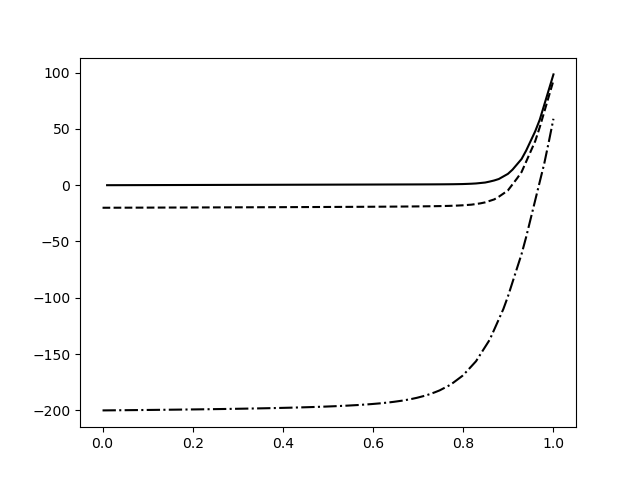

In [4]:
# # create some fake data
Nc = 1 # number of fake datasets
V = np.linspace(0,1,100) # voltage
Gfrac = np.asarray([1]) # Gfrac, i.e. light intensity

X_dimensions = ['Vext','Gfrac'] # dimensions of the X array
X = np.array([[x,y] for y in Gfrac for x in V ] ) # X array
Xplot = Gfrac # X array for plotting

# Generate the fake data to fit
degradation_run = True
True_paramsList = []

# define the degradation of kdirect
kvals = np.geomspace(5e-18,5e-17,1) # simulate degradation of kdirect

dda = Drift_diffusion_agent(path2simu=path2simu) # instantiate the agent


X1 = np.array([[x,0] for x in V ] ) # X array
y1 = dda.DriftDiffusion_relative(X1,params,X_dimensions=X_dimensions, max_jobs=1)
remove = np.where(X1[:,0]==0)[0]
X1 = np.delete(X1,remove,axis=0)
y1 = np.delete(y1,remove,axis=0)
X2 = np.array([[x,0.1] for x in V ] ) # X array
y2 = dda.DriftDiffusion_relative(X2,params,X_dimensions=X_dimensions, max_jobs=1)
X3 = np.array([[x,1] for x in V ] ) # X array
y3 = dda.DriftDiffusion_relative(X3,params,X_dimensions=X_dimensions, max_jobs=1)

plt.plot(X1[:,0],y1,'-',color='black')
plt.plot(X2[:,0],y2,'--',color='black')
plt.plot(X3[:,0],y3,'-.',color='black')

# Start the optimization

In [5]:
n_jobs = 1 # was 4
n_jobs_init = 1 # was 4
n_yscale=20 # was 20
n_initial_points = 5 # was 200
n_BO = 200 # was 60
n_BO_warmstart = 80 # was 5


targets = []
targets.append({'model':partial(dda.DriftDiffusion_relative,X_dimensions=X_dimensions,max_jobs=1),'target_name':'MSE JV 0 sun','data':{'X':X1,'y':y1,
                'X_dimensions':['Vext','Gfrac'],'X_units':['V','sun'],'y_dimension':'Current density','y_unit':r'$A/m²$'},'weight':1,'target_weight':1,'axis_type':'log'})
targets.append({'model':partial(dda.DriftDiffusion_relative,X_dimensions=X_dimensions,max_jobs=1),'target_name':'MSE JV 0.1 sun','data':{'X':X2,'y':y2,
                'X_dimensions':['Vext','Gfrac'],'X_units':['V','sun'],'y_dimension':'Current density','y_unit':r'$A/m²$'},'weight':1,'target_weight':1,'axis_type':'log'})
targets.append({'model':partial(dda.DriftDiffusion_relative,X_dimensions=X_dimensions,max_jobs=1),'target_name':'MSE JV 1 sun','data':{'X':X3,'y':y3, 
                'X_dimensions':['Vext','Gfrac'],'X_units':['V','sun'],'y_dimension':'Current density','y_unit':r'$A/m²$'},'weight':1,'target_weight':1,'axis_type':'log'})

In [6]:
mo = MooBOtorch(params=params,res_dir=res_dir)
mo.targets = targets

r = mo.EvhiOptimizer(n_jobs = n_jobs, n_initial_points = n_initial_points, n_BO = n_BO, n_jobs_init=None,obj_type='MSE',loss='linear',threshold=1000)

Initializing the experiment with 5 initial points
Running 200 batches of 1 jobs each


KeyboardInterrupt: 

In [ ]:
# plot the fit results
fit_results = []
kwargs_plot_res = {'x_scaling':1,'xaxis_label':'Voltage [V]','xscale_type':'linear','y_scaling':1/10,'yaxis_label':'Current density [mA cm$^2$]','yscale_type':'linear','norm_data':False,'delog':False,'figsize':(10,10),'savefig':False,'figname':'JV_fits','figdir':'temp'}

for num,t in enumerate(mo.targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')

    dda.plot_fit_res(t,mo.params,'Vext',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,mo.params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = dda.get_param_dict(mo.params) # get fitparameters (and fixed ones) as dict
pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict] # convert to list of lists

# produce output excel file with data, fitparameters and FOMs
fn_xlsx = 'fits_results.xlsx'
namecols = X_dimensions + ['Jexp','Jfit']
# delete old file if it exists
if os.path.exists(os.path.join(res_dir,fn_xlsx)):
    os.remove(os.path.join(res_dir,fn_xlsx))

with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
    for i,t in enumerate(mo.targets):
        if 'target_name' in t.keys():
            tname = t['target_name']
        else: 
            tname = 'data'
        namecols = X_dimensions + [tname+'_exp',tname+'_fit']
        df = pd.DataFrame(fit_results[i],columns=namecols)
        df.to_excel(writer, sheet_name = tname+f'_{i}')
    
    df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
    df.to_excel(writer, sheet_name = f'params')

In [ ]:
# plot the parameters evolution
param_plot = dda.plot_params([mo.params],kwargs={'savefig':False,'figname':'plot_param','figdir':'temp','nrows':1,'ncols':len(params),'figsize':(10,10)})


In [ ]:
# Clean output files from simulation folders
from boar.SIMsalabim_utils.CleanFolder import *

Do_Cleaning =True # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('logjob',path2simu)
    # os.remove(mo.path2oldxy) # remove the old_xy.json file if it exists
    # delete warmstart folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'warmstart/')):
        shutil.rmtree(os.path.join(os.getcwd(),'warmstart/'))
    # delete temp folder if it exists
    # if os.path.exists(os.path.join(os.getcwd(),'temp/')):
    #     shutil.rmtree(os.path.join(os.getcwd(),'temp/'))

